In [1]:
import numpy as np
from mpitree.tree import DecisionTreeClassifier

np.random.seed(42)


In [2]:
m, n = 10, 3
n_classes = 2


In [3]:
X = np.random.choice([f"f{i}" for i in range(n)], (m, n))
y = np.random.randint(n_classes, size=m)


In [4]:
X


array([['f2', 'f0', 'f2'],
       ['f2', 'f0', 'f0'],
       ['f2', 'f1', 'f2'],
       ['f2', 'f2', 'f2'],
       ['f0', 'f2', 'f1'],
       ['f0', 'f1', 'f1'],
       ['f1', 'f1', 'f0'],
       ['f0', 'f1', 'f1'],
       ['f0', 'f0', 'f0'],
       ['f2', 'f2', 'f2']], dtype='<U2')

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [6]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print(clf)


┌── feature_0
│  ├── feature_1 [f0]
│  │  └── class: 1 [f2]
│  │  └── class: 0 [f1]
│  │  └── class: 1 [f0]
│  └── class: 1 [f2]
│  └── class: 1 [f1]


In [7]:
# test `proba` attribute

proba = clf.predict_proba(X_test)

assert proba.shape[1] == n_classes
assert ((proba >= 0.0) & (proba <= 1.0)).all()
assert (np.isclose(np.sum(proba, axis=1), 1.0)).all()


In [8]:
clf.score(X_test, y_test)


0.5

In [9]:
def cmp(a, b):
    # display(a.export_graphviz())
    print(a)
    assert str(a).splitlines() == b.split("\n")


In [10]:
# check not fitted
from sklearn.exceptions import NotFittedError

try:
    a = DecisionTreeClassifier()
    str(a)
except NotFittedError as e:
    print(e)


This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.


In [11]:
# empty dataset

try:
    X, y = [[]], []
    DecisionTreeClassifier().fit(X, y)
except ValueError as e:
    print(e)


Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required.


In [12]:
# single instance

X, y = [["f0"]], np.zeros(1, dtype=int)

cmp(
    DecisionTreeClassifier().fit(X, y),
    """\
└── class: 0""",
)


└── class: 0


In [13]:
# multiple instance, same label

X, y = np.full((5, 1), "f0"), np.zeros(5, dtype=int)

cmp(
    DecisionTreeClassifier().fit(X, y),
    """\
└── class: 0""",
)


└── class: 0


In [14]:
# multiple same instances

X, y = np.full((3, 2), ["f0", "f1"]), [1, 1, 0]

cmp(
    DecisionTreeClassifier().fit(X, y),
    """\
└── class: 1""",
)


└── class: 1


In [15]:
# empty partitioned dataset

X, y = [["f0", "f0"], ["f0", "f1"], ["f1", "f2"], ["f2", "f1"]], [1, 0, 1, 1]

cmp(
    DecisionTreeClassifier().fit(X, y),
    """\
┌── feature_0
│  ├── feature_1 [f0]
│  │  └── class: 1 [f2]
│  │  └── class: 0 [f1]
│  │  └── class: 1 [f0]
│  └── class: 1 [f2]
│  └── class: 1 [f1]""",
)


┌── feature_0
│  ├── feature_1 [f0]
│  │  └── class: 1 [f2]
│  │  └── class: 0 [f1]
│  │  └── class: 1 [f0]
│  └── class: 1 [f2]
│  └── class: 1 [f1]


In [16]:
# testing depth and is_leaf

X, y = [["f0", "f0"], ["f0", "f1"], ["f1", "f2"], ["f2", "f1"]], [1, 0, 1, 1]

from collections import deque


def bfs(source):
    queue = deque([source])
    while queue:
        node = queue.popleft()
        yield node
        queue.extend(node.children.values())


clf = DecisionTreeClassifier().fit(X, y)

for depth, node in enumerate(bfs(clf.tree_), start=1):
    assert all(n.depth == depth for n in node.children.values())
    assert not node.is_leaf if node.children else node.is_leaf


In [17]:
X, y = [["f0", "f0"], ["f0", "f1"], ["f1", "f2"], ["f2", "f1"]], [1, 0, 1, 1]

cmp(
    DecisionTreeClassifier(max_depth=0).fit(X, y),
    """\
└── class: 1""",
)

cmp(
    DecisionTreeClassifier(max_depth=1).fit(X, y),
    """\
┌── feature_0
│  └── class: 1 [f2]
│  └── class: 1 [f1]
│  └── class: 1 [f0]""",
)


└── class: 1
┌── feature_0
│  └── class: 1 [f2]
│  └── class: 1 [f1]
│  └── class: 1 [f0]


In [18]:
cmp(
    DecisionTreeClassifier(min_samples_split=0).fit(X, y),
    """\
┌── feature_0
│  ├── feature_1 [f0]
│  │  └── class: 1 [f2]
│  │  └── class: 0 [f1]
│  │  └── class: 1 [f0]
│  └── class: 1 [f2]
│  └── class: 1 [f1]""",
)

cmp(
    DecisionTreeClassifier(min_samples_split=4).fit(X, y),
    """\
┌── feature_0
│  └── class: 1 [f2]
│  └── class: 1 [f1]
│  └── class: 1 [f0]""",
)


┌── feature_0
│  ├── feature_1 [f0]
│  │  └── class: 1 [f2]
│  │  └── class: 0 [f1]
│  │  └── class: 1 [f0]
│  └── class: 1 [f2]
│  └── class: 1 [f1]
┌── feature_0
│  └── class: 1 [f2]
│  └── class: 1 [f1]
│  └── class: 1 [f0]


In [19]:
test_cases = [
    (np.array([["0"]]), np.array([0])),
    (np.array([["0", "1"]]), np.array([0])),
]

# X = np.arange(2).reshape(1, 2).astype(str)
# y = np.arange(1)

for D in test_cases:
    X, y = D

    feature_idx = 0
    level = "0"

    mask = X[:, feature_idx] == level

    X_new = np.delete(X[mask], feature_idx, axis=1)
    y_new = y[mask]

    print(X_new, y_new)


[] [0]
[['1']] [0]


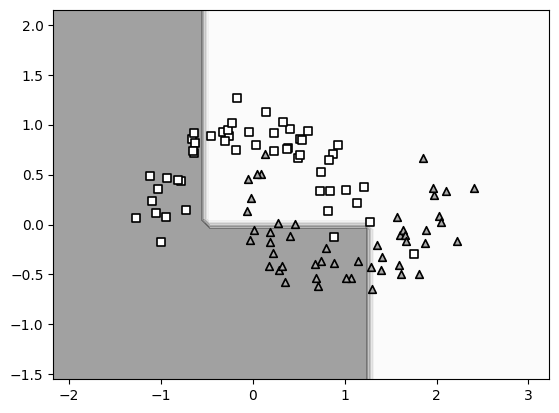

In [20]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

clf = DecisionTreeClassifier().fit(X, y)

# add noisy instance to existing dataset
X = np.insert(X, 0, [[1.75, -0.3]], axis=0)
y = np.insert(y, 0, [0], axis=0)

n_classes = np.unique(y)
colors = "w", "darkgray"
markers = "s", "^"

plt.figure()

x_min, x_max = X[:, 0].min() - 0.9, X[:, 0].max() + 0.9
y_min, y_max = X[:, 1].min() - 0.9, X[:, 1].max() + 0.9

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4, cmap="Greys")

for t, c, marker in zip(n_classes, colors, markers):
    plt.scatter(
        X[y == t, 0],
        X[y == t, 1],
        c=c,
        s=30,
        linewidth=1.2,
        marker=marker,
        edgecolors="k",
        label=t,
    )